In [1]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
import os

## Leitura e limpeza do csv com colunas específicas

In [2]:
def leitor_csv_zip(caminho_zip: str, colunas: list[str]) -> pd.DataFrame:
    """
    Lê um CSV de dentro de um arquivo .zip, usando apenas as colunas necessárias.
    """
    try:
        with zipfile.ZipFile(caminho_zip, 'r') as z:
            # lista todos os arquivos dentro do zip
            arquivos = z.namelist()
            # pega só os que terminam com .csv
            csvs = [arq for arq in arquivos if arq.lower().endswith(".csv")]

            if not csvs:
                print(f"Nenhum arquivo .csv encontrado dentro de {caminho_zip}")
                return pd.DataFrame()

            # por simplicidade, vamos usar o primeiro CSV encontrado
            csv_principal = csvs[0]
            print(f"Lendo {csv_principal} de dentro de {caminho_zip}")

            with z.open(csv_principal) as f:
                quadro = pd.read_csv(f, usecols=colunas, low_memory=False)

        # Padroniza colunas para minúsculas, igual ao leitor de .csv solto
        quadro.columns = [c.lower() for c in quadro.columns]
        return quadro

    except Exception as e:
        print(f"Erro ao ler {caminho_zip}: {e}")
        return pd.DataFrame()


def leitor_geral_especifico_zip(caminhos_zip: list[str], colunas: list[str]) -> pd.DataFrame:
    """
    Lê vários .zip (cada um contendo um CSV de dengue) e concatena tudo em um único DataFrame.
    """
    dados_finais = pd.DataFrame()

    for caminho in caminhos_zip:
        quadro = leitor_csv_zip(caminho, colunas)
        if not quadro.empty:
            dados_finais = pd.concat([dados_finais, quadro], ignore_index=True)

    print(f"Total de linhas após leitura geral (zip): {len(dados_finais)}")
    print(f"Colunas do DataFrame final: {list(dados_finais.columns)}")
    return dados_finais

def converter_datas(quadro: pd.DataFrame) -> pd.DataFrame:
    """
    Converte DT_SIN_PRI e DT_NOTIFIC para datetime.
    """
    if "dt_sin_pri" in quadro.columns:
        quadro["dt_sin_pri"] = pd.to_datetime(
            quadro["dt_sin_pri"],
            errors="coerce"
        )

    if "dt_notific" in quadro.columns:
        quadro["dt_notific"] = pd.to_datetime(
            quadro["dt_notific"],
            errors="coerce"
        )

    return quadro

def filtrar_ano_minimo(quadro: pd.DataFrame, ano_minimo: int = 2020) -> pd.DataFrame:
    """
    Remove linhas com NU_ANO menor que 'ano_minimo' (padrão: 2020).

    Útil para descartar notificações de 2019 que aparecem no CSV de 2020,
    mas que não queremos considerar na análise 2020–2025.
    """
    if "nu_ano" not in quadro.columns:
        print("Aviso: coluna 'nu_ano' não encontrada. Nenhum filtro de ano aplicado.")
        return quadro

    # Garante que nu_ano é numérico
    quadro["nu_ano"] = pd.to_numeric(quadro["nu_ano"], errors="coerce")

    antes = len(quadro)
    quadro_filtrado = quadro[quadro["nu_ano"] >= ano_minimo].copy()
    depois = len(quadro_filtrado)

    print(f"Filtrar ano >= {ano_minimo}: {antes} -> {depois} linhas.")
    return quadro_filtrado

## Filtragem classificados com dengue

In [3]:
# Remove casos com classi_fin considerado descartado
def filtrar_classificados(quadro: pd.DataFrame) -> pd.DataFrame:
    """
    Remove casos descartados (CLASSI_FIN == 5).
    """
    if "classi_fin" not in quadro.columns:
        print("Aviso: coluna 'classi_fin' não encontrada. Nenhum filtro aplicado.")
        return quadro

    quadro["classi_fin"] = pd.to_numeric(quadro["classi_fin"], errors="coerce")
    antes = len(quadro)
    quadro_filtrado = quadro[quadro["classi_fin"] != 5].copy()
    depois = len(quadro_filtrado)

    print(f"Filtrar classificados: {antes} -> {depois} linhas (descartados removidos).")
    return quadro_filtrado

## Contagem semanal e anual de SP

In [4]:
def contagem_semanal_uf(quadro: pd.DataFrame, uf_cod: int = 35) -> pd.DataFrame:
    """
    Retorna um DataFrame com o número de casos por ano e semana epidemiológica
    para uma UF específica (padrão: 35 = São Paulo).
    """
    df = quadro.copy()

    # Filtrar UF
    df = df[df["sg_uf_not"] == uf_cod]

    # Garantir que sem_not é numérico e não nulo
    df = df[df["sem_not"].notna()]
    df["sem_not"] = pd.to_numeric(df["sem_not"], errors="coerce")
    df = df[df["sem_not"].notna()]

    # Extrair semana epidemiológica (últimos 2 dígitos, ex: 202415 -> 15)
    df["semana_ep"] = (df["sem_not"] % 100).astype(int)

    semana = (
        df.groupby(["nu_ano", "semana_ep"], as_index=False)
          .size()
          .rename(columns={"size": "casos"})
    )

    return semana


def contagem_anual_uf(quadro: pd.DataFrame, uf_cod: int = 35) -> pd.DataFrame:
    """
    Retorna um DataFrame com o número total de casos por ano para uma UF específica.
    """
    df = quadro.copy()
    df = df[df["sg_uf_not"] == uf_cod]

    ano = (
        df.groupby("nu_ano", as_index=False)
          .size()
          .rename(columns={"size": "casos"})
    )

    return ano

## Resumo temporal por ano

In [5]:
def resumo_temporal_por_ano(semana_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Recebe o DataFrame de contagem semanal (nu_ano, semana_ep, casos)
    e calcula estatísticas descritivas da série de 'casos' POR ANO.
    """
    if semana_df.empty:
        return pd.DataFrame(), pd.DataFrame()

    def _estatisticas(g: pd.DataFrame) -> pd.Series:
        serie = g["casos"]
        media = serie.mean()
        mediana = serie.median()
        moda = serie.mode().tolist()
        desvio = serie.std()
        iqr_val = iqr(serie, nan_policy="omit")
        return pd.Series({
            "media": media,
            "mediana": mediana,
            "moda": moda[0] if len(moda) > 0 else None,
            "desvio_padrao": desvio,
            "iqr": iqr_val,
        })

    resumo = (
        semana_df
        .groupby("nu_ano")
        .apply(_estatisticas)
        .reset_index()
    )

    # Calcular outliers por ano
    lista_outliers = []
    for ano, g in semana_df.groupby("nu_ano"):
        serie = g["casos"]
        q1, q3 = serie.quantile([0.25, 0.75])
        lim_inf = q1 - 1.5 * (q3 - q1)
        lim_sup = q3 + 1.5 * (q3 - q1)
        out = g[(g["casos"] < lim_inf) | (g["casos"] > lim_sup)].copy()
        out["nu_ano"] = ano
        lista_outliers.append(out)

    outliers = (
        pd.concat(lista_outliers, ignore_index=True)
        if lista_outliers else pd.DataFrame()
    )

    return resumo, outliers

## Graficos

In [6]:
def grafico_linha_semanal_sp(semana_df: pd.DataFrame):
    """
    Plota a evolução semanal dos casos de dengue em SP,
    com uma linha por ano (NU_ANO), usando semana_ep (1–52/53).
    """
    if semana_df.empty:
        print("DataFrame semanal vazio – nenhum gráfico gerado.")
        return

    # Garantir ordenação por ano e semana
    semana_df = semana_df.sort_values(["nu_ano", "semana_ep"])

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=semana_df,
        x="semana_ep",
        y="casos",
        hue="nu_ano",
        marker="o"
    )

    plt.title("Evolução semanal dos casos de dengue – São Paulo (2020–2025)")
    plt.xlabel("Semana epidemiológica")
    plt.ylabel("Número de casos")
    plt.xticks(range(1, semana_df["semana_ep"].max() + 1, 2))  # de 2 em 2 pra não poluir
    plt.legend(title="Ano")
    plt.tight_layout()
    plt.show()

def grafico_barras_anual_sp(ano_df: pd.DataFrame):
    """
    Plota um gráfico de barras com o total anual de casos em SP.
    """
    if ano_df.empty:
        print("DataFrame anual vazio – nenhum gráfico gerado.")
        return

    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=ano_df,
        x="nu_ano",
        y="casos"
    )

    plt.title("Total anual de casos de dengue – São Paulo (2020–2025)")
    plt.xlabel("Ano")
    plt.ylabel("Número de casos")
    plt.tight_layout()
    plt.show()

## Execução completa

Lendo DENGBR20.csv de dentro de dados/DENGBR20.zip
Lendo DENGBR21.csv de dentro de dados/DENGBR21.zip
Lendo DENGBR22.csv de dentro de dados/DENGBR22.zip
Lendo DENGBR23.csv de dentro de dados/DENGBR23.zip
Lendo DENGBR24.csv de dentro de dados/DENGBR24.zip
Lendo DENGBR25.csv de dentro de dados/DENGBR25.zip
Total de linhas após leitura geral (zip): 13344402
Colunas do DataFrame final: ['dt_notific', 'sem_not', 'nu_ano', 'sg_uf_not', 'dt_sin_pri', 'nu_idade_n', 'cs_sexo', 'classi_fin']
Filtrar classificados: 13344402 -> 12327380 linhas (descartados removidos).
Filtrar ano >= 2020: 12327380 -> 12323901 linhas.
Primeiras linhas da contagem semanal em SP (agora com semana_ep):
   nu_ano  semana_ep  casos
0    2021          1    433
1    2021          2    909
2    2021          3   1299
3    2021          4   1799
4    2021          5   2598

Contagem anual em SP:
   nu_ano    casos
0    2020   206491
1    2021   158526
2    2022   350984
3    2023   337196
4    2024  2182002
5    2025   8509

C:\Users\guyar\AppData\Local\Temp\ipykernel_52500\2563151268.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_estatisticas)


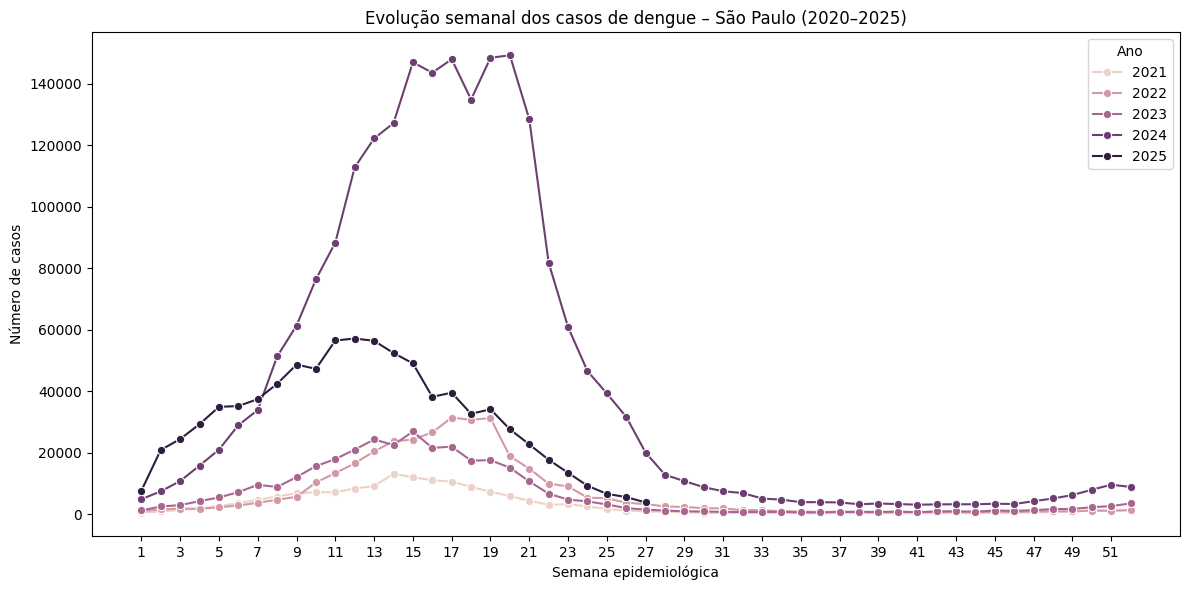

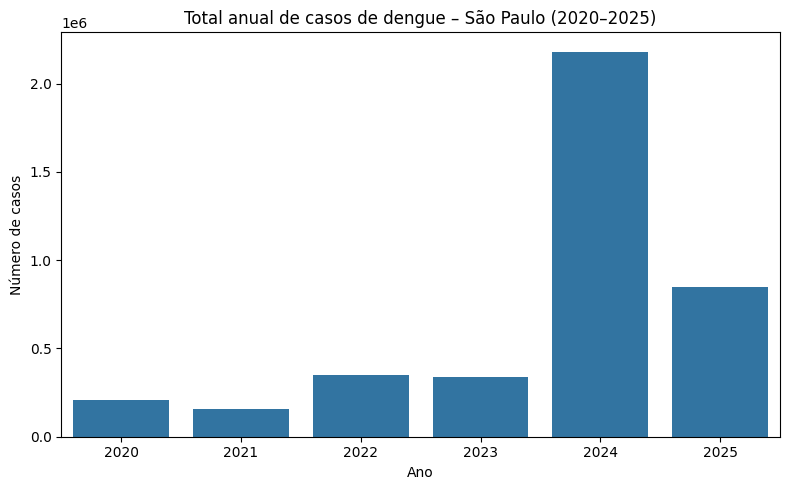

In [7]:
def executar_evolucao_temporal_sp(caminhos_zip: list[str], colunas_necessarias: list[str]):
    # 1) Ler e limpar
    dados = leitor_geral_especifico_zip(caminhos_zip, colunas_necessarias)
    dados = converter_datas(dados)
    dados = filtrar_classificados(dados)
    dados = filtrar_ano_minimo(dados, ano_minimo=2020)

    # 2) Contagens
    semana_sp = contagem_semanal_uf(dados, uf_cod=35)
    ano_sp = contagem_anual_uf(dados, uf_cod=35)

    print("Primeiras linhas da contagem semanal em SP (agora com semana_ep):")
    print(semana_sp.head())

    print("\nContagem anual em SP:")
    print(ano_sp)

    # 3) Estatísticas por ano
    resumo_ano, outliers = resumo_temporal_por_ano(semana_sp)

    print("\nResumo estatístico por ano – São Paulo:")
    print(resumo_ano)

    print("\nOutliers semanais por ano (semanas muito acima/abaixo do esperado):")
    print(outliers)

    # 4) Gráficos
    grafico_linha_semanal_sp(semana_sp)
    grafico_barras_anual_sp(ano_sp)


caminhos_zip = [
    "dados/DENGBR20.zip",
    "dados/DENGBR21.zip",
    "dados/DENGBR22.zip",
    "dados/DENGBR23.zip",
    "dados/DENGBR24.zip",
    "dados/DENGBR25.zip",
]

colunas_necessarias = [
    "DT_NOTIFIC",
    "SEM_NOT",
    "NU_ANO",
    "SG_UF_NOT",
    "DT_SIN_PRI",
    "NU_IDADE_N",
    "CS_SEXO",
    "CLASSI_FIN",
]

executar_evolucao_temporal_sp(caminhos_zip, colunas_necessarias)